# Named Entity Recognition

## Importing important libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import TimeDistributed
from tensorflow import keras


## Loading Data

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


## Data Visualization

In [3]:
data = pd.read_csv('ner_dataset.csv' ,encoding='latin1')
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [4]:
print("TAGS")
print(data['Tag'].value_counts())

TAGS
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


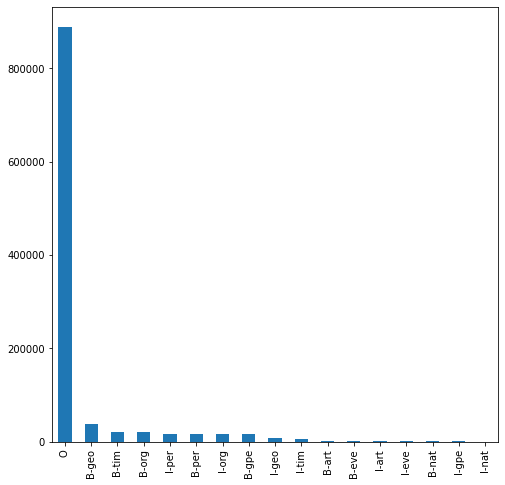

In [5]:
plt.figure(figsize=(8,8))
data['Tag'].value_counts().plot(kind='bar')
plt.show()

## Data Preparation

We make a list of words, tags and sentences


In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
tags = list(set(data['Tag'].values))
sentences = SentenceGetter(data).sentences
print('Number of sentences:', len(sentences))
print('Number of words:', len(words))
print('Number of tags:', len(tags))

Number of sentences: 47959
Number of words: 35179
Number of tags: 17


## Feature extraction

We transform words, tags and sentences into numbers based on their index. This is also known as label encoding, but because our sentences are is a list of lists of tuples we could not use e.g. LabelEncoder.


In [8]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [9]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X[0])
for i in X[0]:
  print(idx2word[i], end = ' ')

[5274, 30432, 3731, 33582, 8299, 33166, 8476, 19258, 4012, 795, 20400, 32801, 17585, 22317, 1311, 795, 13463, 30432, 5025, 10333, 23797, 26068, 264, 589]
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 

In [10]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
print(y[0])
for i in y[0]:
  print(idx2tag[i], end = ' ')

[14, 14, 14, 14, 14, 14, 0, 14, 14, 14, 14, 14, 0, 14, 14, 14, 14, 14, 1, 14, 14, 14, 14, 14]
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 

Our sentences and tags need to be the same length

In [11]:
max_len = 50

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(words)-1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O'])
print(X[0])
print(y[0])

[ 5274 30432  3731 33582  8299 33166  8476 19258  4012   795 20400 32801
 17585 22317  1311   795 13463 30432  5025 10333 23797 26068   264   589
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[14 14 14 14 14 14  0 14 14 14 14 14  0 14 14 14 14 14  1 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14]


In [12]:
y = [to_categorical(i, num_classes=len(tags)) for i in y]

In [13]:
print(y[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.

## Splitting data into train and test set

In [14]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1)
print("Train shapes : X = {}, y = {}".format(train_x.shape, (len(train_y), max_len)))
print("Test shapes : X = {}, y = {}".format(test_x.shape, (len(test_y), max_len)))

Train shapes : X = (43163, 50), y = (43163, 50)
Test shapes : X = (4796, 50), y = (4796, 50)


## Training the model

In [15]:
# create and fit the LSTM network

input = Input(shape=(max_len, ))
model = Embedding(input_dim=len(words), output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)  # softmax output layer

model = keras.Model(input, out)

opt = keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]) 



In [16]:
history = model.fit(train_x, np.array(train_y), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1080/1080 [==============================] - 203s 184ms/step - loss: 0.0828 - accuracy: 0.9774 - val_loss: 0.0490 - val_accuracy: 0.9852
Epoch 2/10
1080/1080 [==============================] - 197s 183ms/step - loss: 0.0359 - accuracy: 0.9886 - val_loss: 0.0450 - val_accuracy: 0.9866
Epoch 3/10
1080/1080 [==============================] - 197s 183ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0472 - val_accuracy: 0.9858
Epoch 4/10
1080/1080 [==============================] - 197s 183ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0496 - val_accuracy: 0.9860
Epoch 5/10
1080/1080 [==============================] - 196s 181ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0537 - val_accuracy: 0.9855
Epoch 6/10
1080/1080 [==============================] - 198s 183ms/step - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.0566 - val_accuracy: 0.9851
Epoch 7/10
1080/1080 [==============================] - 198s 184ms/step - loss: 0.0175 - accuracy: 0.9940 - val_

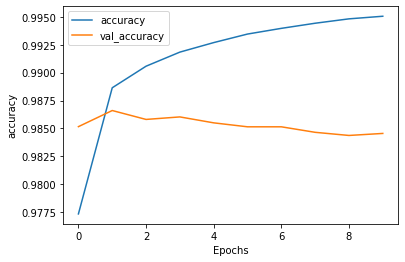

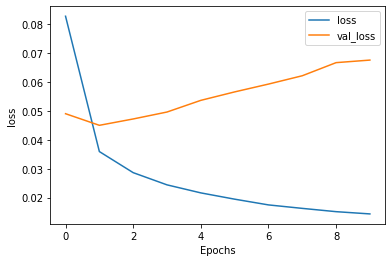

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
i = 156
p = model.predict(np.array([test_x[i]]))
p = np.argmax(p, axis=-1)

print("{:15} {:15} {}".format("Word", "Predicted tag", "True tag"))
for w, pred, true in zip(test_x[i], p[0], test_y[i]):
  if idx2word[w] != "ENDPAD":
    true_tag = list(true).index(1.0)
    print("{:15}:{:15} ({})".format(idx2word[w], tags[pred], tags[true_tag]))

Word            Predicted tag   True tag
Just           :O               (O)
as             :O               (O)
they           :O               (O)
were           :O               (O)
expiring       :O               (O)
,              :O               (O)
they           :O               (O)
exclaimed      :O               (O)
,              :O               (O)
"              :O               (O)
O              :B-geo           (O)
foolish        :O               (O)
creatures      :O               (O)
that           :O               (O)
we             :O               (O)
are            :O               (O)
,              :O               (O)
for            :O               (O)
the            :O               (O)
sake           :O               (O)
of             :O               (O)
a              :O               (O)
little         :O               (O)
pleasure       :O               (O)
we             :O               (O)
have           :O               (O)
destroyed      :O      

In [19]:
total = 0
count = 1

for i in range(4796): #axis 0 size
  p = model.predict(np.array([test_x[i]]))
  p = np.argmax(p, axis=-1)
  for w, pred, true in zip(test_x[i], p[0], test_y[i]):
    total += 1
    if idx2word[w] != "ENDPAD":
      true_tag = list(true).index(1.0)
      if tags[pred] == tags[true_tag]:
        count += 1

print('Accuracy:', round((count/total)*100, 2))

Accuracy: 42.05
